#### A/B Testing  
Here, we have been given a dataset that has information of users visiting a website and then subsequently whether they buy a product or not which is indicated by converted (1 - yes, 0 - No)

Suppose our team came up with a new design of the website with the hope that more users would end up buing the product. As a Data Scientist, I would be curious to collect some data and make sure if we have data to support that claim. Hence we perform an A/B test. Fortunately, we have been provided the data set with 2 sets of groups - control (users shown old design) and treatment (users shown new design) groups. Each group should have unique set of users. 

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./ab_test.csv')

In [3]:
df.head()

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [48]:
# check null values
df.isnull().sum()

id           0
time         0
con_treat    0
page         0
converted    0
hour         0
dtype: int64

In [58]:
# find duplicates and drop (can keep the first occurence). If datetime column is given, we can sort by time and keep the first. 
df = df.drop_duplicates(subset=['id'], keep='first')

In [61]:
assert df.shape[0] == df['id'].nunique()

In [62]:
control = df[df['con_treat'] == 'control']
treatment = df[df['con_treat'] == 'treatment']

In [142]:
print(f'control group statistics: mean - {control.converted.mean():.2f}, std - {control.converted.std():.2f}')
print(f'Treatment group statistics: mean - {treatment.converted.mean():.2f}, std - {treatment.converted.std():.2f}')

control group statistics: mean - 0.12, std - 0.33
Treatment group statistics: mean - 0.12, std - 0.32


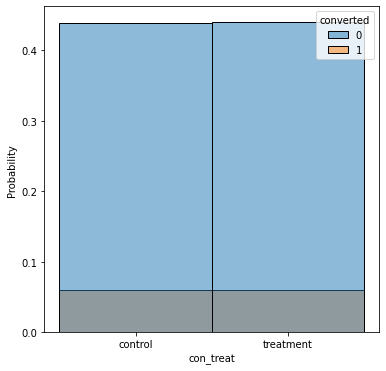

In [145]:
fig = plt.figure(figsize=(6,6))
sns.histplot(x = 'con_treat', hue = 'converted', data = df, stat='probability')
plt.savefig('./control_treatment_distribution.png', )

#### check the distribution of time (minute granularity is given).   
If datetime is goven, we can make sure that both groups were
shown the website during similar times (like both websites were shown during all hours and days)

we can check the density distribution of the minute across both control and treatment groups



In [77]:
df['minute'] = df['time'].apply(lambda x: int(str(x).split(':')[0]))

<ipython-input-77-3028f959e097>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df['time'].apply(lambda x: int(str(x).split(':')[0]))


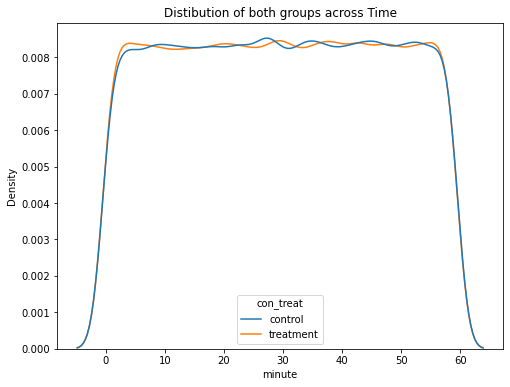

<Figure size 432x288 with 0 Axes>

In [151]:
plt.figure(figsize=(8,6))
sns.kdeplot(x = 'minute', data = df, hue = 'con_treat')
plt.title('Distibution of both groups across Time')
plt.figure('Density distribution of 2 groups wrt Time')
plt.savefig('./Density distribution wrt Time for both groups')

#### statistical test
Null hypo - both control and treatment group are similar and difference is statiscally insignificant. 

we set alpha = 0.05  
        power = 1 - beta = 0.8  (probability of rejecting null hypothesis when its false)
        effect size, lets say we want to observe a change of conversion from 12 % to 14%
Based on this, we can calculate the required sample size

In [79]:
df.head()

,id,time,con_treat,page,converted,hour,minute
0,851104,11:48.6,control,old_page,0,11,11
1,804228,01:45.2,control,old_page,0,1,1
2,661590,55:06.2,treatment,new_page,0,55,55
3,853541,28:03.1,treatment,new_page,0,28,28
4,864975,52:26.2,control,old_page,1,52,52


#### Here we perform a Z-test since data is sufficiently large and the assumption is that with a large sample, the distribution is normal

In [95]:
import scipy.stats as stats
import statsmodels.stats.api as sms
import math

# Some plot styling preferences
# plt.style.use('seaborn-whitegrid')
# font = {'family' : 'Helvetica',
#         'weight' : 'bold',
#         'size'   : 14}

# mpl.rc('font', **font)

def ret_samplesize(effect_a = 0.12, effect_b = 0.14, power = 0.8, alpha = 0.01, ratio = 1):
    effect_size = sms.proportion_effectsize(effect_a, effect_b)    # Calculating effect size based on our expected rates

    required_n = sms.NormalIndPower().solve_power(
        effect_size, 
        power=power, 
        alpha=alpha, 
        ratio=ratio,
        alternative='two-sided'
        )                                                  # Calculating sample size needed

    required_n = math.ceil(required_n)                          # Rounding up to next whole number                          
    return required_n

In [96]:
ret_samplesize(alpha=0.01)

6596

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


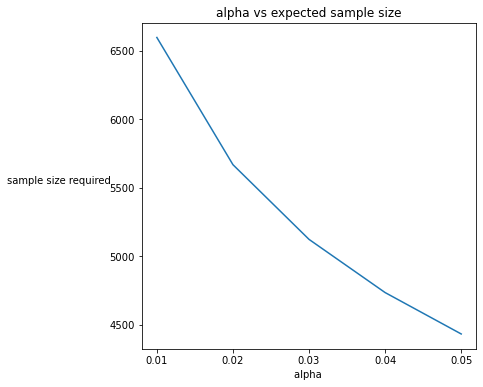

In [149]:
# with decreasing p-value, see how the number of samples required increase

pvalues = [0.05, 0.04, 0.03, 0.02, 0.01]
expected_sample_size = []

for pvalue in pvalues:
    
    size = ret_samplesize(alpha = pvalue)
    expected_sample_size.append(size)
    

fig = plt.figure(figsize=(6,6))
plt.title('alpha vs expected sample size')
plt.xlabel('alpha ')
plt.ylabel('sample size required', rotation = 0, labelpad=50)


plt.xticks(pvalues)

sns.lineplot(pvalues, expected_sample_size)
plt.savefig('./alpha vs expected sample size.png')

In [45]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = df[df['con_treat'] == 'control']['converted']
treatment_results = df[df['con_treat'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()

successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]



In [113]:
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.24
p-value: 0.216
ci 95% for control group: [0.119, 0.122]
ci 95% for treatment group: [0.117, 0.121]


#### Here we see that the p-value of the test is 0.21 which is > 0.05 (significance value). Hence we fail to reject the null hypothesis.   
Also the 95% confidence interval for the treatment group is from 11.7% to 12.1% which overlaps with the control group interval. Infact the conversion in treatment has dropped when compared to the control group. Hence its not feasible to deploy the new design. 